#NUEVA (EJECUTAR)

In [ ]:
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install midi2audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.6 MB 17.8 MB/s 
     |████████████████████████████████| 51 kB 9.2 MB/s 
  Created wheel for pretty-midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591955 sha256=da17521a8cca6f3f7822fe5b34c4e4c214247b6ea9a2f5483c68fa9d00ce9012
  Stored in directory: /root/.cache/pip/wheels/ad/74/7c/a06473ca8dcb63efb98c1e67667ce39d52100f837835ea18fa
Successfully built pretty-midi
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth1 libqt5x11extras5 qsynth
Suggested packages:
  fluid-soundfont-gs timidity jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libf

In [ ]:
from google.colab import drive
#drive.mount('/content/drive')
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
import pretty_midi
import warnings
import os
import collections
import datetime
import itertools
import fluidsynth
import glob
import pathlib
import seaborn as sns
import tensorflow as tf
import pickle
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
!tar -xvf /content/drive/MyDrive/prueba_lakh/lmd_matched.tar.gz -C /content/drive/MyDrive/prueba_lakh

Se truncaron las últimas líneas 5000 del resultado de transmisión.
lmd_matched/N/F/K/TRNFKDA128F428B174/
lmd_matched/N/F/K/TRNFKDA128F428B174/884c88ef3d3e63d234bdec6a3cab82cf.mid
lmd_matched/N/F/K/TRNFKDA128F428B174/7bc72587f6bbabff250b49b0e40dfc2e.mid
lmd_matched/N/F/K/TRNFKDA128F428B174/9f0ab4d72b157c6e8c3f94669f2211f0.mid
lmd_matched/N/F/K/TRNFKOC128F92F1E67/
lmd_matched/N/F/K/TRNFKOC128F92F1E67/3a8135dcf97dd36795a995c1d27c2188.mid
lmd_matched/N/F/K/TRNFKYR128F147B5BB/
lmd_matched/N/F/K/TRNFKYR128F147B5BB/3c09acc8910287d111f79d4fd76ac48b.mid
lmd_matched/N/F/K/TRNFKIB128F93333A1/
lmd_matched/N/F/K/TRNFKIB128F93333A1/22d10638402f34400751af5b3b26bd47.mid
lmd_matched/N/F/K/TRNFKIB128F93333A1/d94a25edc9a376ca3848baed4d87e7ce.mid
lmd_matched/N/F/K/TRNFKIB128F93333A1/0a5c9a01c9997d58c2f373d8ce84f48d.mid
lmd_matched/N/F/G/
lmd_matched/N/F/G/TRNFGQF128F933D979/
lmd_matched/N/F/G/TRNFGQF128F933D979/c36fe492229d1cdea4f0268db06edce4.mid
lmd_matched/N/F/G/TRNFGID12903CC6047/
lmd_matched/N/F/G/TR

##extracción features y genres

### Funcion features

In [ ]:
# -*- coding: utf-8 -*-
"""
Spyder Editor

This is a temporary script file.
"""

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pretty_midi
#import librosa
#import librosa.display
#import mir_eval
#import mir_eval.display
#import IPython.display
import os
import json
import warnings
from joblib import Parallel, delayed
import pickle

# Local path constants
DATA_PATH = '/content/drive/MyDrive/prueba_lakh'
RESULTS_PATH = '/content/drive/MyDrive/prueba_lakh'
# Path to the file match_scores.json distributed with the LMD
SCORE_FILE = os.path.join(RESULTS_PATH, 'match_scores.json')

# Utility functions for retrieving paths
def msd_id_to_dirs(msd_id):
    """Given an MSD ID, generate the path prefix.
    E.g. TRABCD12345678 -> A/B/C/TRABCD12345678"""
    return os.path.join(msd_id[2], msd_id[3], msd_id[4], msd_id)

def msd_id_to_mp3(msd_id):
    """Given an MSD ID, return the path to the corresponding mp3"""
    return os.path.join(DATA_PATH, 'msd', 'mp3',
                        msd_id_to_dirs(msd_id) + '.mp3')

#def msd_id_to_h5(h5):
#    """Given an MSD ID, return the path to the corresponding h5"""
#    return os.path.join(DATA_PATH, 'lmd_matched_h5',
#                        msd_id_to_dirs(msd_id) + '.h5')

def get_midi_path(msd_id, midi_md5, kind):
    """Given an MSD ID and MIDI MD5, return path to a MIDI file.
    kind should be one of 'matched' or 'aligned'. """
    return os.path.join(DATA_PATH, 'lmd_{}'.format(kind),
                        msd_id_to_dirs(msd_id), midi_md5 + '.mid')

def normalize_features(features):
    """
    This function normalizes the features to the range [-1, 1]
    
    @input features: The array of features.
    @type features: List of float
    
    @return: Normalized features.
    @rtype: List of float
    """
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    return [tempo, num_sig_changes, resolution, time_sig_1, time_sig_2]


def get_features(path):
    """
    This function extracts the features from a midi file when given its path.
    
    @input path: The path to the midi file.
    @type path: String
    
    @return: The extracted features.
    @rtype: List of float
    """
    
        # Test for Corrupted Midi Files
    try:    
      with warnings.catch_warnings():
        #warnings.simplefilter("error")
        file = pretty_midi.PrettyMIDI(path)
            
        tempo = file.estimate_tempo()
        num_sig_changes = len(file.time_signature_changes)
        resolution = file.resolution
        ts_changes = file.time_signature_changes
        ts_1 = 4
        ts_2 = 4
        if len(ts_changes) > 0:
          ts_1 = ts_changes[0].numerator
          ts_2 = ts_changes[0].denominator
        return normalize_features([tempo, num_sig_changes, resolution, ts_1, ts_2])

    except:
      return None

def process(i,loaded_list,scores):
    
    conf_list = []
    md5_list = []
    msd_id = loaded_list[0][i]
    
    for midi_md5, score in scores[msd_id].items():
      conf_list.append(score)
      md5_list.append(midi_md5)

    score_index = conf_list.index(max(conf_list))

    matched_midi_path = get_midi_path(msd_id, md5_list[score_index], 'aligned')
    #print(matched_midi_path)
    features = get_features(matched_midi_path)
    
    return [msd_id, features, loaded_list[1][i]]

with open('/content/drive/MyDrive/prueba_lakh/hottness.m', 'rb') as f:
        loaded_list = pickle.load(f)


with open(SCORE_FILE) as f:
    scores = json.load(f)
#len(loaded_list[0])
if __name__ == '__main__':
    data_matrix = Parallel(n_jobs=-4,verbose=10)(delayed(process)(i,loaded_list,scores) for i in range(len(loaded_list[0])))


with open('/content/drive/MyDrive/prueba_lakh/alignedMIDIData.pkl', 'wb') as f:
        pickle.dump(data_matrix, f)
      #print '  {} with confidence score {}'.format(midi_md5, score)

[Parallel(n_jobs=-4)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-4)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   6 out of   6 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   7 out of   7 | elapsed:    1.3s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   8 out of   8 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done   9 out of   9 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-4)]: Done 13152 out of 13152 | elapsed: 118.7min finished


##generos y train data

In [ ]:
def get_genres(path):
    """
    This function reads the genre labels and puts it into a pandas DataFrame.
    @input path: The path to the genre label file.
    @type path: String
    @return: A pandas dataframe containing the genres and midi IDs.
    @rtype: pandas.DataFrame
    """
    ids = []
    genres = []
    with open(path) as f:
        line = f.readline()
        while line:
            if line[0] != '#':
                [x, y, *_] = line.strip().split("\t")
                ids.append(x)
                genres.append(y)
            line = f.readline()
    genre_df = pd.DataFrame(data={"Genre": genres, "TrackID": ids})
    return genre_df

# Get the Genre DataFrame
genre_path = "/content/drive/MyDrive/prueba_lakh/msd_tagtraum_cd1.cls"
genre_df = get_genres(genre_path)
# Create Genre List and Dictionary
label_list = list(set(genre_df.Genre))
label_dict = {lbl: label_list.index(lbl) for lbl in label_list}

# Print to Visualize
#print(genre_df.head(), end="\n\n")
#print(label_list, end="\n\n")
#print(label_dict, end="\n\n")

#with open('/content/drive/MyDrive/prueba_lakh/data_matrix.pkl', 'rb') as d:
#        midi_data = pickle.load(d)

#with open('/content/drive/MyDrive/prueba_lakh/matchedMIDIData.pkl', 'rb') as f:
#        midi_data = pickle.load(f)

with open('/content/drive/MyDrive/prueba_lakh/alignedMIDIData.pkl', 'rb') as f:
        midi_data = pickle.load(f)

#Merge generos con midi data
data_df = pd.DataFrame(midi_data, columns=['TrackID', 'MidiData','Hotttnesss'])
data_df = pd.merge(data_df, genre_df, on='TrackID', how='inner')
data_df = data_df.drop(['TrackID', 'Hotttnesss'], axis=1)
data_df = data_df.mask(data_df.eq('None')).dropna()

label_dict = {'Vocal': 0, 'Electronic': 1, 'International': 2, 'Country': 3, 'New Age': 4,
  'Pop_Rock': 5, 'Folk': 6, 'Jazz': 7, 'Reggae': 8, 'Latin': 9, 'Blues': 10, 'Rap': 11, 'RnB': 12}

#Encode generos
generos = np.asarray(data_df['Genre'])
y_all_train = np.asarray([np.asarray(label_dict[generos[i]]) for i in range(0,generos.size)])
y_all_train = y_all_train.reshape(-1,1)
enc = OneHotEncoder(sparse=False)
y_enc = enc.fit_transform(y_all_train)

x_all_train = data_df['MidiData'].to_list()
x_all_train = np.asarray(x_all_train).astype('float32')

#Separamos todos los datos en train y en test
x_train, x_test, y_train, y_test = train_test_split(x_all_train, y_enc, test_size=0.10)

#Separamos el train en train y validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

#print(f"Train X: {x_train} Train Y:{y_train}")
print(f"Train X Shape: {x_train.shape} Train Y Shape:{y_train.shape}")
#print(f"Val X: {x_val} Val Y:{y_val}")
print(f"Val X Shape: {x_val.shape} Val Y Shape:{y_val.shape}")
#print(f"Test X: {x_test} Test Y:{y_test}")
print(f"Test X Shape: {x_test.shape} Test Y Shape:{y_test.shape}")

Train X Shape: (1833, 5) Train Y Shape:(1833, 13)
Val X Shape: (612, 5) Val Y Shape:(612, 13)
Test X Shape: (272, 5) Test Y Shape:(272, 13)


##Modelo

In [ ]:
model= Sequential()
model.add(Dense(32, input_shape=(5,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
#model_history = model.fit(x = x_train, y = y_train, validation_data=(x_val, y_val), batch_size=50, epochs=100, callbacks=[EarlyStopping( monitor='loss', patience=2)] , verbose=False)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 32)                192       
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 13)                221       
                                                                 
Total params: 941
Trainable params: 941
Non-trainable params: 0
_________________________________________________________________


##Gráficos

accuracy:  0.6985294117647058
precision:  0.08333333333333333
f1:  0.06854256854256854


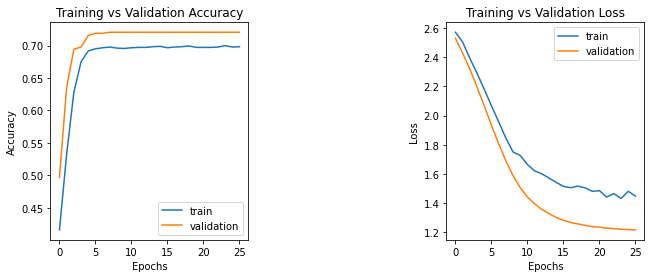

In [ ]:
# Gráficos
#plotting
fig, axs =plt.subplots(1,2)
plt.subplots_adjust(wspace=1, right=1.5)
#accuracy plot
axs[0].plot(model_history.history['accuracy'])
axs[0].plot(model_history.history['val_accuracy'])
axs[0].set(xlabel='Epochs', ylabel='Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend(['train', 'validation'])
#loss plot 
axs[1].plot(model_history.history['loss'])
axs[1].plot(model_history.history['val_loss'])
axs[1].set(xlabel='Epochs', ylabel='Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend(['train', 'validation'])

#predicciones
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,-1)
y_real = y_test
y_real = np.argmax(y_real,-1)
#print(y_pred.shape)
#print(y_real.shape)
print("accuracy: ", accuracy_score (y_pred, y_real,))
print("precision: ", precision_score (y_pred, y_real, average = 'macro'))
print("f1: ", f1_score (y_pred, y_real, average = 'macro'))

#Save predictions to csv
test_df = pd.DataFrame({"Test Values":y_real[:], "Predicted Values": y_pred[:]})
test_df.to_csv ("/content/drive/MyDrive/prueba_lakh/genre_predictions.csv",index=False)

#OLD (NO EJECUTAR SOLO REFERENCIA)

##Instalación fluid synth, pretty midi, midi2audio

In [ ]:
!pip install pretty_midi
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth
!pip install midi2audio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (1.1.9-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: unknown command "upgrade"


##Carga de Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, plot_confusion_matrix, precision_score, recall_score
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Input, Dropout
import pretty_midi
import warnings
import os
import collections
import datetime
import itertools
import fluidsynth
import glob
import pathlib
import seaborn as sns
import tensorflow as tf
import pickle
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Descompresión lmd_matched (no es necesario y demora sus 5 minutos)

In [ ]:
!tar -xvf /content/drive/MyDrive/prueba_lakh/lmd_matched.tar.gz

##Obtener Géneros/Hotttnesss, parearlos con path al MIDI, obtener features y cargar un audio del MIDI (Multi-Class y Regression)

##Obtener géneros de archivo tagtraum

In [ ]:

def get_genres(path):
    """
    This function reads the genre labels and puts it into a pandas DataFrame.
    
    @input path: The path to the genre label file.
    @type path: String
    
    @return: A pandas dataframe containing the genres and midi IDs.
    @rtype: pandas.DataFrame
    """
    ids = []
    genres = []
    with open(path) as f:
        line = f.readline()
        while line:
            if line[0] != '#':
                [x, y, *_] = line.strip().split("\t")
                ids.append(x)
                genres.append(y)
            line = f.readline()
    genre_df = pd.DataFrame(data={"Genre": genres, "TrackID": ids})
    return genre_df

# Get the Genre DataFrame
genre_path = "/content/drive/MyDrive/prueba_lakh/msd_tagtraum_cd1.cls"
genre_df = get_genres(genre_path)

# Create Genre List and Dictionary
label_list = list(set(genre_df.Genre))
label_dict = {lbl: label_list.index(lbl) for lbl in label_list}

# Print to Visualize
print(genre_df.head(), end="\n\n")
print(label_list, end="\n\n")
print(label_dict, end="\n\n")

      Genre             TrackID
0  Pop_Rock  TRAAAAK128F9318786
1       Rap  TRAAAAW128F429D538
2  Pop_Rock  TRAAABD128F429CF47
3      Jazz  TRAAAED128E0783FAB
4  Pop_Rock  TRAAAEF128F4273421

['New Age', 'Jazz', 'Electronic', 'Pop_Rock', 'Folk', 'International', 'Latin', 'Country', 'Rap', 'Reggae', 'RnB', 'Blues', 'Vocal']

{'New Age': 0, 'Jazz': 1, 'Electronic': 2, 'Pop_Rock': 3, 'Folk': 4, 'International': 5, 'Latin': 6, 'Country': 7, 'Rap': 8, 'Reggae': 9, 'RnB': 10, 'Blues': 11, 'Vocal': 12}



##Obtener los path de los midi y parearlos con el género (tambien se puede parear con hotttnesss)

In [ ]:
def get_matched_midi(midi_folder, genre_df):
#def get_matched_midi(midi_folder, genre_df, hot_df): 
    """
    This function loads in midi file paths that are found in the given folder, puts this data into a
    pandas DataFrame, then matches each entry with a genre described in get_genres.
    
    @input midi_folder: The path to the midi files.
    @type midi_folder: String
    @input genre_df: The genre label dataframe generated by get_genres.
    @type genre_df: pandas.DataFrame
    
    @return: A dataframe of track id and path to a midi file with that track id.
    @rtype: pandas.DataFrame
    """
    # Get All Midi Files
    track_ids, file_paths = [], []
    for dir_name, subdir_list, file_list in os.walk(midi_folder):
        if len(dir_name) == 45:
            track_id = dir_name[27:]
            file_path_list = ["/".join([dir_name, file]) for file in file_list]
            for file_path in file_path_list:
                track_ids.append(track_id)
                file_paths.append(file_path)
    all_midi_df = pd.DataFrame({"TrackID": track_ids, "Path": file_paths})
    
    # Inner Join with Genre Dataframe
    df = pd.merge(all_midi_df, genre_df, on='TrackID', how='inner')
    #df2 = pd.merge(df, hot_df, on='TrackID', how='inner')
    #return df.drop(["TrackID"], axis=1)
    return df
    #return df2.drop(["TrackID"],axis=1)

# Obtain DataFrame with Matched Genres to File Paths
midi_path = "/content/lmd_matched"
with open('/content/drive/MyDrive/prueba_lakh/hottness.m', 'rb') as f:
        loaded_list = pickle.load(f)

ll_df = pd.DataFrame({"TrackID": loaded_list[0], "Hotttnesss": loaded_list[1]})
#matched_midi_df = get_matched_midi(midi_path, genre_df, ll_df)
matched_midi_df = get_matched_midi(midi_path, genre_df)

# Print to Check Correctness
print(matched_midi_df)



Empty DataFrame
Columns: [Path, Genre, TrackID]
Index: []


##Obtener features de data_matrix.pkl y merge con df de genres, mas separar en train, test, val

In [ ]:
from sklearn.preprocessing import OneHotEncoder
with open('/content/drive/MyDrive/prueba_lakh/data_matrix.pkl', 'rb') as d:
        loaded_list2 = pickle.load(d)

data_df = pd.DataFrame(loaded_list2, columns=['TrackID', 'MidiData','Hotttnesss'])
data_df = pd.merge(data_df, matched_midi_df, on='TrackID', how='inner')
data_df = data_df.drop(['TrackID', 'Path'], axis=1)
data_df['Genre_label'] = data_df['Genre'].map(label_dict)
#Remove None and NaN values
data_df = data_df.mask(data_df.eq('None')).dropna()
x_all_train = data_df['MidiData'].to_list()
x_all_train = np.asarray(x_all_train).astype('float32')
y = np.array(data_df['Genre_label']).astype(int)
y_encoded = np.array((data_df['Genre'], data_df['Genre_label']))
enc = OneHotEncoder(handle_unknown='ignore')
y_encoded = enc.fit(y_encoded)
print(y_encoded)


#print(x_all_train.shape)
#print(x_all_train)
#print(y.shape)
#print(y)

#Separamos todos los datos en train y en test
x_train, x_test, y_train, y_test = train_test_split(x_all_train, y, test_size=0.10)

#print(x_train, y_train)
#print(x_train.shape, y_train.shape)
#print(x_test, y_test)
#print(x_test.shape, y_test.shape)

#Separamos el train en train y validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

#print(x_train)
#print(x_train, y_train)
print(x_train.shape, y_train.shape)
#print(x_val, y_val)
print(x_val.shape, y_val.shape)


ValueError: ignored

##Obtener features de los MIDI (Tutorial)

In [ ]:
%%time
def normalize_features(features):
    """
    This function normalizes the features to the range [-1, 1]
    
    @input features: The array of features.
    @type features: List of float
    
    @return: Normalized features.
    @rtype: List of float
    """
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    return [tempo, resolution, time_sig_1, time_sig_2]


def get_features(path):
    """
    This function extracts the features from a midi file when given its path.
    
    @input path: The path to the midi file.
    @type path: String
    
    @return: The extracted features.
    @rtype: List of float
    """
    try:
        # Test for Corrupted Midi Files
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            file = pretty_midi.PrettyMIDI(path)
            
            tempo = file.estimate_tempo()
            num_sig_changes = len(file.time_signature_changes)
            resolution = file.resolution
            ts_changes = file.time_signature_changes
            ts_1 = 4
            ts_2 = 4
            if len(ts_changes) > 0:
                ts_1 = ts_changes[0].numerator
                ts_2 = ts_changes[0].denominator
            return normalize_features([tempo, num_sig_changes, resolution, ts_1, ts_2])
    except:
        return None


def extract_midi_features(path_df):
    """
    This function takes in the path DataFrame, then for each midi file, it extracts certain
    features, maps the genre to a number and concatenates these to a large design matrix to return.
    
    @input path_df: A dataframe with paths to midi files, as well as their corresponding matched genre.
    @type path_df: pandas.DataFrame
    
    @return: A matrix of features along with label.
    @rtype: numpy.ndarray of float
    """
    all_features = []
    for index, row in path_df.iterrows():
        features = get_features(row.Path)
        genre = label_dict[row.Genre]
        if features is not None:
            features.append(genre)
            all_features.append(features)
    return np.array(all_features)

labeled_features = extract_midi_features(matched_midi_df)
print(labeled_features)

[]
CPU times: user 38min 50s, sys: 3min 16s, total: 42min 6s
Wall time: 40min 15s


##Save MIDI features (se demora aprox 40 minutos en obtener las features)

In [ ]:
np.save('/content/drive/MyDrive/prueba_lakh/MIDI_genre_and_features.npy',labeled_features)

##Load MIDI features

In [ ]:
labeled_features = np.load('/content/drive/MyDrive/prueba_lakh/MIDI_genre_and_features.npy')
print(labeled_features)

[]


##Reproducir un MIDI como audio

In [ ]:
#44 KHz
_SAMPLING_RATE = 44000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

#Displaying audio from dataFrame and locating by id
print(ll_df.loc[ll_df['TrackID'] == 'TREEETR12903CED883'])
print(matched_midi_df.loc[matched_midi_df['TrackID'] == 'TREEETR12903CED883'])
musiquita = pretty_midi.PrettyMIDI(matched_midi_df.iloc[0].Path)
display_audio(musiquita)




                 TrackID           Hotttnesss
6045  TREEETR12903CED883  [0.675762044254343]
              TrackID                                               Path  \
0  TREEETR12903CED883  /content/lmd_matched/E/E/E/TREEETR12903CED883/...   
1  TREEETR12903CED883  /content/lmd_matched/E/E/E/TREEETR12903CED883/...   
2  TREEETR12903CED883  /content/lmd_matched/E/E/E/TREEETR12903CED883/...   
3  TREEETR12903CED883  /content/lmd_matched/E/E/E/TREEETR12903CED883/...   

            Hotttnesss  
0  [0.675762044254343]  
1  [0.675762044254343]  
2  [0.675762044254343]  
3  [0.675762044254343]  


## Carga archivo data_matrix.pkl, obtención de train_data y separar en train, test, val  (Regression)

In [ ]:
with open('/content/drive/MyDrive/prueba_lakh/data_matrix.pkl', 'rb') as d:
        loaded_list2 = pickle.load(d)

data_df = pd.DataFrame(loaded_list2, columns=['TrackID', 'MidiData','Hotttnesss'])
#Remove None and NaN values
data_df = data_df.mask(data_df.eq('None')).dropna()

x_all_train = data_df['MidiData'].to_list()
x_all_train = np.asarray(x_all_train).astype('float32')
y = data_df['Hotttnesss'].to_list()
y = np.asarray(y).astype('float32')

#print(x_all_train.shape)
#print(x_all_train)
#print(y.shape)
#print(y)

#Separamos todos los datos en train y en test
x_train, x_test, y_train, y_test = train_test_split(x_all_train, y, test_size=0.10)

#print(x_train, y_train)
#print(x_train.shape, y_train.shape)
#print(x_test, y_test)
#print(x_test.shape, y_test.shape)

#Separamos el train en train y validation
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25)

#print(x_train)
#print(x_train, y_train)
print(x_train.shape, y_train.shape)
#print(x_val, y_val)
print(x_val.shape, y_val.shape)


(8833, 5) (8833, 1)
(2945, 5) (2945, 1)


## Separar features en train, val y test (Multi-Class Tutorial)

In [ ]:
# Shuffle Entire Dataset to Make Random
labeled_features = np.random.permutation(labeled_features)

print(labeled_features)
# Partition into 3 Sets
num = len(labeled_features)
num_training = int(num * 0.6)
num_validation = int(num * 0.8)
training_data = labeled_features[:num_training]
validation_data = labeled_features[num_training:num_validation]
test_data = labeled_features[num_validation:]

# Separate Features from Labels
num_cols = training_data.shape[1] - 1
training_features = training_data[:, :num_cols]
validation_features = validation_data[:, :num_cols]
test_features = test_data[:, :num_cols]

# Format Features for Multi-class Classification
num_classes = len(label_list)
training_labels = training_data[:, num_cols].astype(int)
validation_labels = validation_data[:, num_cols].astype(int)
test_labels = test_data[:, num_cols].astype(int)

# Function for One-Hot Encoding
def one_hot(labels):
    """
    This function encodes the labels using one-hot encoding.
    
    @input num_classes: The number of genres/classes.
    @type num_classes: int
    @input labels: The genre labels to encode.
    @type labels: numpy.ndarray of int
    
    @return: The one-hot encoding of the labels.
    @rtype: numpy.ndarray of int
    """
    return np.eye(num_classes)[labels].astype(int)

# Print to Check Dimentions and to Visualize
print(test_features[:10])
print(test_labels[:10])
print(one_hot(test_labels)[:10])

[]


IndexError: ignored

## Modelo Sequential con 3 Dense, 3 Dropout, capa final activation linear(Regression) (no ejecutar)

In [ ]:
model = Sequential()
model.add(Dense(5,input_shape=(5,), activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(5,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='linear'))
model.compile(loss='mae', optimizer='adam', metrics=['mae'])
model_history = model.fit(x = x_train, y = y_train, validation_data=(x_val,y_val) , batch_size=20, epochs=100, callbacks=[EarlyStopping( monitor='loss', patience=2)] , verbose=False)


## Modelo Sequential multi-class Classification (ejecutar)

In [ ]:
model= Sequential()
model.add(Dense(5, input_shape=(5,), activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1, activation='relu'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_history = model.fit(x = x_train, y = y_train, validation_data=(x_val y_val), batch_size=50, epochs=100, callbacks=[EarlyStopping( monitor='loss', patience=2)] , verbose=False)

## Plotting y save predictions to csv

(1309, 1)
[0.43300506 0.3041695  0.46048483 ... 0.21508032 0.78508645 0.34092274]
[0.51209086 0.5208264  0.5002412  ... 0.5002412  0.5096505  0.5002412 ]


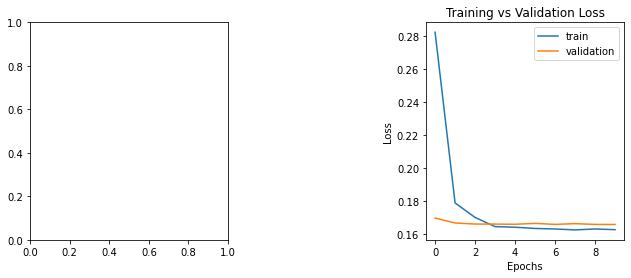

In [ ]:
#plotting
fig, axs =plt.subplots(1,2)
plt.subplots_adjust(wspace=1, right=1.5)
#accuracy plot
axs[0].plot(model_history.history['accuracy'])
axs[0].plot(model_history.history['val_accuracy'])
axs[0].set(xlabel='Epochs', ylabel='Accuracy')
axs[0].set_title('Training vs Validation Accuracy')
axs[0].legend(['train', 'validation'])
#loss plot 
axs[1].plot(model_history.history['loss'])
axs[1].plot(model_history.history['val_loss'])
axs[1].set(xlabel='Epochs', ylabel='Loss')
axs[1].set_title('Training vs Validation Loss')
axs[1].legend(['train', 'validation'])

#predicciones
y_pred = model.predict(x_test)
print(y_test.shape)
print(y_test[:,0])
print(y_pred[:,0])
#print("accuracy: ", accuracy_score (y_test, y_pred))
#print("precision: ", precision_score (y_test, y_pred, average = 'macro'))
#print("f1: ", f1_score (y_test, y_pred, average = 'macro'))

#Save predictions to csv
test_df = pd.DataFrame({"Test Values":y_test[:,0], "Predicted Values": y_pred[:,0]})
test_df.to_csv ("/content/drive/MyDrive/prueba_lakh/lakh_predictions.csv",index=False)